In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import iqr
import warnings
warnings.filterwarnings('ignore')

In [2]:
def extract_time(json):
    try:
        # Also convert to int since update_time will be string.  When comparing
        # strings, "10" is smaller than "2".
        return int(json['content']['timestamp'])
    except KeyError:
        return 0

In [3]:
data = []
for d, s, f in os.walk("/Users/jeremypcleung/coding-analytics/2018"):
    for file in f:
        if "." not in file:
            current_file=open(os.path.join(d, file))
            for line in current_file:
                if len(line) > 1:
                    data.append(json.JSONDecoder().decode(line))

data.sort(key=extract_time)
                    
with open('data-all.json', 'w') as outfile:
    json.dump(data, outfile)

In [4]:
users = {}
for entry in data:
    if entry["user_id"] not in users:
        users[entry["user_id"]] = []
    users[entry["user_id"]].append(entry)

In [5]:
levels = {}
for user, items in users.items():
    if user not in levels:
        levels[user] = set()
    for item in items:
        if item["content"]["action"] == "Start":
            levels[user].add(item["content"]["stage_id"])
            
delete = []
for level, item in levels.items():
    levels[level] = list(levels[level])
    if len(item) == 0:
        delete.append(level)
        
for d in delete:
    del levels[d]
        
count = {}
for level, item in levels.items():
    for stage in item:
        if stage not in count:
            count[stage] = []
        count[stage].append(level)

#print(count)

In [6]:
details = {}
#current_users = ['4658', '427', '6234', '6242', '5745', '5362', '5746', '5360', '5508', '6265', '5364', '5242', '6268', '5277', '5363', '6274', '6036', '6277', '6278', '5700', '6144', '5055', '6310', '5332', '6314', '5195', '6317', '6205', '6365', '6535', '6347', '6416', '6576', '6582', '5037', '6345', '6346', '6367', '6599', '6614', '1770', '5729', '5895', '6041', '6079', '6112']
current_levels = ['23','31']

for user_id in users:
    for index in range(len(users[user_id])):
        if users[user_id][index]["content"]["action"] == "Start" and users[user_id][index]["content"]["stage_id"] in current_levels and user_id != '0' and user_id != '427':
            current = True
            stage_id = users[user_id][index]["content"]["stage_id"]
            if user_id not in details:
                details[user_id] = {}
            if stage_id not in details[user_id]:
                details[user_id][stage_id] = {"numRuns": 0, "totalDuration": 0, "startToGet": [], "startToRun": [], "numResets": 0, "success": [], "getToPut": []}
            startTime = int(users[user_id][index]["content"]["timestamp"])
            getTime = 0
            runTime = 0
            while(current):
                index += 1
                if len(users[user_id]) != index and ("stage_id" in users[user_id][index]["content"] and users[user_id][index]["content"]["stage_id"] == stage_id):
                    if int(users[user_id][index]["content"]["timestamp"]) - int(users[user_id][index-1]["content"]["timestamp"]) > 3600000:
                        endTime = int(users[user_id][index-1]["content"]["timestamp"])
                        details[user_id][stage_id]["totalDuration"] += endTime - startTime
                        startTime = int(users[user_id][index]["content"]["timestamp"])
                if len(users[user_id]) == index or ("stage_id" in users[user_id][index]["content"] and users[user_id][index]["content"]["stage_id"] != stage_id):
                    current = False
                    endTime = int(users[user_id][index-1]["content"]["timestamp"])
                    details[user_id][stage_id]["totalDuration"] += endTime - startTime
                    details[user_id][stage_id]["success"].append(0)
                elif users[user_id][index]["content"]["action"] == "Default":
                    current = False
                    endTime = int(users[user_id][index-1]["content"]["timestamp"])
                    details[user_id][stage_id]["totalDuration"] += endTime - startTime
                    details[user_id][stage_id]["success"].append(0)
                elif users[user_id][index]["content"]["action"] == "Win":
                    current = False
                    endTime = int(users[user_id][index]["content"]["timestamp"])
                    details[user_id][stage_id]["totalDuration"] += endTime - startTime
                    details[user_id][stage_id]["success"].append(1)
                elif users[user_id][index]["content"]["action"] == "Leave":
                    current = False
                    endTime = int(users[user_id][index]["content"]["timestamp"])
                    details[user_id][stage_id]["totalDuration"] += endTime - startTime
                    details[user_id][stage_id]["success"].append(0)
                elif users[user_id][index]["content"]["action"] == "Get":
                    if getTime == 0:
                        getTime = int(users[user_id][index]["content"]["timestamp"])
                        details[user_id][stage_id]["startToGet"].append(getTime-startTime)
                    getTime = int(users[user_id][index]["content"]["timestamp"])
                elif users[user_id][index]["content"]["action"] == "Put":
                    putTime = int(users[user_id][index]["content"]["timestamp"])
                    if putTime-getTime < 1800000:
                        details[user_id][stage_id]["getToPut"].append(putTime-getTime)
                elif users[user_id][index]["content"]["action"] == "Run":
                    details[user_id][stage_id]["numRuns"] += 1
                    if runTime == 0:
                        runTime = int(users[user_id][index]["content"]["timestamp"])
                        details[user_id][stage_id]["startToRun"].append(runTime-startTime)
                elif users[user_id][index]["content"]["action"] == "Reset":
                    details[user_id][stage_id]["numResets"] += 1

In [7]:
delete = set()
for index, user_id in enumerate(details):
    for i, stage_id in enumerate(details[user_id]):
        if len(details[user_id][stage_id]["startToGet"])==0 or len(details[user_id][stage_id]["startToRun"])==0 or len(details[user_id][stage_id]["getToPut"])==0 or details[user_id][stage_id]["totalDuration"] == 0:
            delete.add(user_id)

for d in delete:
    del details[d]

In [8]:
stats = np.zeros((len(details),len(current_levels),7))
users_list = []
for index, user_id in enumerate(details):
    users_list.append(user_id)
    for i, stage_id in enumerate(details[user_id]):
        stats[index][i][0] = details[user_id][stage_id]["numRuns"]
        stats[index][i][1] = details[user_id][stage_id]["totalDuration"]
        stats[index][i][2] = np.average(details[user_id][stage_id]["startToGet"])
        stats[index][i][3] = np.average(details[user_id][stage_id]["startToRun"])
        stats[index][i][4] = details[user_id][stage_id]["numResets"]
        stats[index][i][5] = np.average(details[user_id][stage_id]["success"])
        stats[index][i][6] = np.average(details[user_id][stage_id]["getToPut"])  

In [9]:
delete = set()

for index, user in enumerate(stats):
    for i, stage in enumerate(stats[index]):
        if stats[index][i][0] == 0:
            delete.add(index)

print(len(stats))
delete = list(delete)
stats = np.delete(stats,delete,axis=0)
users_list = np.delete(users_list,delete,axis=0)
print(len(stats))

1124
134


In [10]:
original_stats = stats.copy()
original_stats = np.reshape(original_stats, (len(original_stats),len(current_levels)*7))
columns = ["Number of Runs", "Total Duration", "Start to first Get Time", "Start to first Run Time", "Number of Resets", "Success Rate", "Get to Put Time"]
users_df = pd.DataFrame(original_stats, index=users_list, columns=np.tile(columns,len(current_levels)))

In [11]:
norm_stats = stats.copy()
norm_stats = np.reshape(norm_stats,(len(norm_stats),len(current_levels)*7))
scaler = MinMaxScaler()
norm_stats = scaler.fit_transform(norm_stats)
norm_stats = np.reshape(norm_stats,(len(norm_stats),len(current_levels),7))

In [12]:
total = []
q1 = []
q3 = []
iqrVal = []
delete = set()
train = norm_stats.copy()
outliers = norm_stats.copy()
train_users = users_list.copy()
outliers_users = users_list.copy()

for index, user in enumerate(norm_stats):
    for ind, stage in enumerate(norm_stats[index]):
        for i, feature in enumerate(norm_stats[index][ind]):
            if len(total)<7:
                total.append([])
            total[i].append(norm_stats[index][ind][i])
            
for i in range(7):
    q1.append(np.percentile(total[i], 25))
    q3.append(np.percentile(total[i], 75))
    iqrVal.append(iqr(total[i]))

for index, user in enumerate(norm_stats):
    for ind, stage in enumerate(norm_stats[index]):
        for i, feature in enumerate(norm_stats[index][ind]):
            if norm_stats[index][ind][i] < q1[i] - 1.5 * iqrVal[i] or norm_stats[index][ind][i] > q3[i] + 1.5 * iqrVal[i]:
                delete.add(index)

delete = list(delete)
train = np.delete(train,delete,axis=0)
outliers = np.take(outliers,delete,axis=0)
train_users = np.delete(train_users,delete,axis=0)
outliers_users = np.take(outliers_users,delete,axis=0)
print(len(train_users))
print(len(outliers_users))

51
83


In [13]:
train = np.reshape(train, (len(train),len(current_levels)*7))
pca = PCA(n_components=2).fit(train)
train_stats = pca.transform(train)
print(pca.components_)

[[ 0.07094241  0.03900862  0.01630205  0.02382026  0.02383121 -0.00105121
   0.60240568  0.20778597  0.26964181  0.00534507  0.05161262  0.04883274
  -0.14302274  0.69838128]
 [ 0.30615952  0.11992491  0.00249049  0.00982623  0.09304583 -0.00277634
  -0.41370564  0.40213687  0.44193058  0.03952773  0.05370084  0.21631667
  -0.54100542 -0.10498253]]


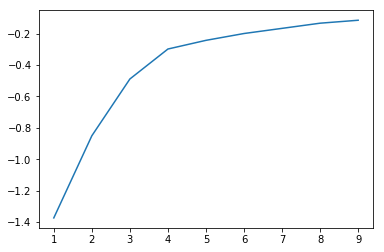

In [14]:
Ks = range(1, 10)
km = [KMeans(n_clusters=i) for i in Ks]
score = [km[i].fit(train_stats).score(train_stats) for i in range(len(km))]
plt.plot(Ks, score)
plt.show()

In [15]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=300, tol=1e-4)
train_predictions = kmeans.fit_predict(train_stats)

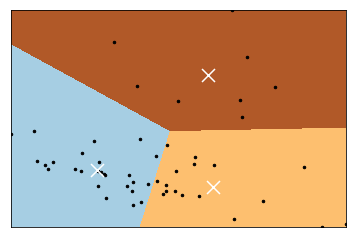

In [16]:
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = train_stats[:, 0].min(), train_stats[:, 0].max()
y_min, y_max = train_stats[:, 1].min(), train_stats[:, 1].max()

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = ((x_max-x_min)/5000 + (y_max-y_min)/5000)/2     # point in the mesh [x_min, x_max]x[y_min, y_max].

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(train_stats[:, 0], train_stats[:, 1], 'k.', markersize=5)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [17]:
outliers = np.reshape(outliers, (len(outliers),len(current_levels)*7))
pca = PCA(n_components=2).fit(outliers)
outliers_stats = pca.transform(outliers)
outliers_predictions = kmeans.predict(outliers_stats)

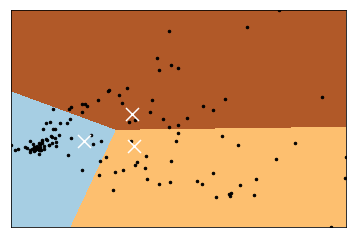

In [18]:
norm_stats = np.reshape(norm_stats, (len(norm_stats),len(current_levels)*7))
pca = PCA(n_components=2).fit(norm_stats)
norm_stats = pca.transform(norm_stats)
stats_predictions = kmeans.predict(norm_stats)

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = norm_stats[:, 0].min(), norm_stats[:, 0].max()
y_min, y_max = norm_stats[:, 1].min(), norm_stats[:, 1].max()

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = ((x_max-x_min)/5000 + (y_max-y_min)/5000)/2     # point in the mesh [x_min, x_max]x[y_min, y_max].

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(norm_stats[:, 0], norm_stats[:, 1], 'k.', markersize=5)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [19]:
users_df['Group'] = stats_predictions
users_df.to_csv("users-groups.csv", sep=',')